In [2]:
import pandas as pd
from os.path import join
import sys
import os
import numpy as np
import tensorflow as tf
sys.path.append("/home/sunzehui/GeneNet/")
from data_utils.pathways.reactome import Reactome, ReactomeNetwork
from config_path import *
import data_utils.data_access
import tensorflow as tf
import sklearn
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras.layers import Activation, Dense, Softmax, Conv1D, Layer, Conv2D
from tensorflow.keras.activations import relu, sigmoid, softmax, tanh
import logging


# Data Preprocess

In [3]:
"""data_reader

Returns:
    _type_: _description_
"""

# Path Define
data_path = DATA_PATH
processed_path = join(DATA_PATH, 'processed')
cached_data = {}
response_filename = join(DATA_PATH, 'processed/response.csv')
cnv_burden_filename = join(DATA_PATH, 'processed/CNV_burden.csv')
gene_important_mutations_only = join(DATA_PATH, "processed/somatic_mutations_important_only.csv")
cnv_filename = join(DATA_PATH, "processed/CNV.csv")
# gene_final_no_silent_no_intron = join(DATA_PATH, "processed/somatic_mutations_important_only.csv")

In [5]:
def load_data(filename, selected_genes=None):
    filename = join(processed_path, filename)
    logging.info(f'loading GeneNet_data from {filename},')
    if filename in cached_data:
        logging.info('loading from memory cached_data')
        data = cached_data[filename]
    else:
        data = pd.read_csv(filename, index_col=0)
        cached_data[filename] = data
    logging.info(f"The loaded dataframe's shape is {data.shape}")

    if 'response' in cached_data:
        logging.info('loading from memory cached_data')
        labels = cached_data['response']
    else:
        labels = get_response()
        cached_data['response'] = labels

    # join with the labels
    _all = data.join(labels, how='inner')
    # 去除response=NA
    _all = _all[~_all['response'].isnull()]

    response = _all['response']
    samples = _all.index

    del _all['response']
    x = _all
    genes = _all.columns

    if selected_genes is not None:
        intersect = set.intersection(set(genes), selected_genes)
        if len(intersect) < len(selected_genes):
            # raise Exception('wrong gene')
            logging.warning('some genes dont exist in the original GeneNet_data set')
        x = x.loc[:, list(intersect)]
        genes = intersect
    logging.info('loaded GeneNet_data %d samples, %d variables, %d responses ' % (x.shape[0], x.shape[1], response.shape[0]))
    logging.info(len(genes))
    return x, response, samples, genes

# Load Tumor mutation burden
# def load_TMB(filename=gene_final_no_silent_no_intron):
#     x, response, samples, genes = load_data(filename)
#     x = np.sum(x, axis=1)
#     x = np.array(x)
#     x = np.log(1. + x)
#     n = x.shape[0]
#     response = response.values.reshape((n, 1))
#     samples = np.array(samples)
#     cols = np.array(['TMB'])
#     return x, response, samples, cols


# def load_CNV_burden(filename=gene_final_no_silent_no_intron):
#     x, response, samples, genes = load_data(filename)
#     x = np.sum(x, axis=1)
#     x = np.array(x)
#     x = np.log(1. + x)
#     n = x.shape[0]
#     response = response.values.reshape((n, 1))
#     samples = np.array(samples)
#     cols = np.array(['TMB'])
#     return x, response, samples, cols


def load_data_type(data_type='gene', cnv_levels=5, cnv_filter_single_event=True, mut_binary=False, selected_genes=None):
    logging.info('loading {}'.format(data_type))
    # if data_type == 'TMB':
    #     x, response, info, genes = load_TMB(gene_important_mutations_only)


    if data_type == 'mut_important':
        x, response, info, genes = load_data(gene_important_mutations_only, selected_genes)
        if mut_binary:
            logging.info('mut_binary = True')
            x[x > 1.] = 1.

    if data_type == 'cnv':
        x, response, info, genes = load_data(cnv_filename, selected_genes)
        if cnv_levels == 3:
            logging.info('cnv_levels = 3')
            # remove single amplification and single delteion, they are usually noisey
            if cnv_levels == 3:
                if cnv_filter_single_event:
                    x[x == -1.] = 0.0
                    x[x == -2.] = 1.0
                    x[x == 1.] = 0.0
                    x[x == 2.] = 1.0
                else:
                    x[x < 0.] = -1.
                    x[x > 0.] = 1.

    if data_type == 'cnv_del':
        x, response, info, genes = load_data(cnv_filename, selected_genes)
        x[x >= 0.0] = 0.
        if cnv_levels == 3:
            if cnv_filter_single_event:
                x[x == -1.] = 0.0
                x[x == -2.] = 1.0
            else:
                x[x < 0.0] = 1.0
        else:  # cnv == 5 , use everything
            x[x == -1.] = 0.5
            x[x == -2.] = 1.0

    if data_type == 'cnv_amp':
        x, response, info, genes = load_data(cnv_filename, selected_genes)
        x[x <= 0.0] = 0.
        if cnv_levels == 3:
            if cnv_filter_single_event:
                x[x == 1.0] = 0.0
                x[x == 2.0] = 1.0
            else:
                x[x > 0.0] = 1.0
        else:  # cnv == 5 , use everything
            x[x == 1.] = 0.5
            x[x == 2.] = 1.0

    if data_type == 'cnv_single_del':
        x, response, info, genes = load_data(cnv_filename, selected_genes)
        x[x == -1.] = 1.0
        x[x != -1.] = 0.0
    if data_type == 'cnv_single_amp':
        x, response, info, genes = load_data(cnv_filename, selected_genes)
        x[x == 1.] = 1.0
        x[x != 1.] = 0.0
    if data_type == 'cnv_high_amp':
        x, response, info, genes = load_data(cnv_filename, selected_genes)
        x[x == 2.] = 1.0
        x[x != 2.] = 0.0
    if data_type == 'cnv_deep_del':
        x, response, info, genes = load_data(cnv_filename, selected_genes)
        x[x == -2.] = 1.0
        x[x != -2.] = 0.0

    # if data_type == 'gene_expression':
    #     x, response, info, genes = load_data(gene_expression, selected_genes)

    # if data_type == 'fusions':
    #     x, response, info, genes = load_data(fusions_filename, None)

    if data_type == 'cnv_burden':
        x, response, info, genes = load_data(cnv_burden_filename, None)

    # if data_type == 'fusion_genes':
    #     x, response, info, genes = load_data(fusions_genes_filename, selected_genes)

    return x, response, info, genes


def get_response():
    logging.info(f'loading response from {response_filename}')
    labels = pd.read_csv(join(processed_path, response_filename))
    labels = labels.set_index('id')
    return labels


# complete_features: make sure all the data_types have the same set of features_processing (genes)
def combine(x_list, y_list, rows_list, cols_list, data_type_list, combine_type, use_coding_genes_only=False):
    cols_list_set = [set(list(c)) for c in cols_list]

    if combine_type == 'intersection':
        cols = set.intersection(*cols_list_set)
    else:
        cols = set.union(*cols_list_set)

    if use_coding_genes_only:
        f = join(data_path, 'genes/HUGO_genes/protein-coding_gene_with_coordinate_minimal.txt')
        coding_genes_df = pd.read_csv(f, sep='\t', header=None)
        coding_genes_df.columns = ['chr', 'start', 'end', 'name']
        coding_genes = set(coding_genes_df['name'].unique())
        cols = cols.intersection(coding_genes)

    # the unique (super) set of genes
    all_cols = list(cols)

    all_cols_df = pd.DataFrame(index=all_cols)  # Empty dataframe in which index is genes

    df_list = []
    for x, y, r, c in zip(x_list, y_list, rows_list, cols_list):
        df = pd.DataFrame(x, columns=c, index=r)  # cols are genes, index is id, right join instances
        df = df.T.join(all_cols_df, how='right')  # df.T index are genes, cols are ids
        df = df.T  # index is id, cols are genes
        # print(f"df.columns are {df.columns}, df.index is {df.index}")
        df = df.fillna(0)  # fill it with 0
        df_list.append(df)
    #  这一步的目的是为了将各种不同类型的数据整合在一起，形成一个以index=gene, data_type为multi-index，
    all_data = pd.concat(df_list, keys=data_type_list, join='inner', axis=1, )

    # 整合完毕之后形成一个columns为多重索引[data_type, gene_name], 在这之后用swaplevel函数将其倒换
    # put genes on the first level and then the GeneNet_data type
    all_data = all_data.swaplevel(i=0, j=1, axis=1)

    # order the columns based on genes, 按照基因字母序进行列排序
    order = all_data.columns.levels[0]  # 选取columns的多重索引的level=0的索引，即gene
    all_data = all_data.reindex(columns=order, level=0)
    # print(f"df.columns are {all_data.columns}, df.index is {all_data.index}")

    x = all_data.values  # 去除掉表头等标签属性，只提取纯数据

    # prepare response
    reordering_df = pd.DataFrame(index=all_data.index)
    y = reordering_df.join(y, how='left') 

    # print(f"df.columns are {y.columns}, df.index is {y.index}")

    y = y.values
    cols = all_data.columns  # [gene, data_type]
    rows = all_data.index  # [id]
    logging.info(
        'After combining, loaded GeneNet_data %d samples, %d variables, %d responses ' % (x.shape[0], x.shape[1], y.shape[0])
    )

    return x, y, rows, cols


def split_cnv(x_df):
    genes = x_df.columns.levels[0]
    x_df.rename(columns={'cnv': 'CNA_amplification'}, inplace=True)
    for g in genes:
        x_df[g, 'CNA_deletion'] = x_df[g, 'CNA_amplification'].replace({-1.0: 0.5, -2.0: 1.0})
        x_df[g, 'CNA_amplification'] = x_df[g, 'CNA_amplification'].replace({1.0: 0.5, 2.0: 1.0})
    x_df = x_df.reindex(columns=genes, level=0)
    return x_df


In [6]:
class DataClass:

    def __init__(self, data_type='mut', account_for_data_type=None, cnv_levels=5,
                 cnv_filter_single_event=True, mut_binary=False,
                 selected_genes=None, combine_type='intersection',
                 use_coding_genes_only=False, drop_AR=False,
                 balanced_data=False, cnv_split=False,
                 shuffle=False, selected_samples=None, training_split=0):

        self.training_split = training_split
        if selected_genes is not None:
            if type(selected_genes) == list:
                # list of genes
                selected_genes = selected_genes
            else:
                # file that will be used to load list of genes
                selected_genes_file = join(data_path, 'genes')
                selected_genes_file = join(selected_genes_file, selected_genes)
                df = pd.read_csv(selected_genes_file, header=0)
                selected_genes = list(df['genes'])

        if isinstance(data_type, list):
            x_list = []
            y_list = []
            rows_list = []
            cols_list = []

            for t in data_type:
                x, y, rows, cols = load_data_type(t, cnv_levels, cnv_filter_single_event, mut_binary, selected_genes)
                x_list.append(x), y_list.append(y), rows_list.append(rows), cols_list.append(cols)
            x, y, rows, cols = combine(x_list, y_list, rows_list, cols_list, data_type, combine_type,
                                       use_coding_genes_only)
            x = pd.DataFrame(x, columns=cols)
        else:
            x, y, rows, cols = load_data_type(data_type, cnv_levels, cnv_filter_single_event, mut_binary,
                                              selected_genes)

        if drop_AR:
            data_types = x.columns.levels[1].unique() # data_type                                        
            ind = True
            if 'cnv' in data_types:
                ind = x[('AR', 'cnv')] <= 0.
            elif 'cnv_amp' in data_types:
                ind = x[('AR', 'cnv_amp')] <= 0.

            if 'mut_important' in data_types:
                ind2 = (x[('AR', 'mut_important')] < 1.)
                ind = ind & ind2
            x = x.loc[ind, ]
            y = y[ind]
            rows = rows[ind]

        if cnv_split:
            x = split_cnv(x)

        if type(x) == pd.DataFrame:
            x = x.values

        if balanced_data:
            pos_ind = np.where(y == 1.)[0]
            neg_ind = np.where(y == 0.)[0]

            n_pos = pos_ind.shape[0]
            n_neg = neg_ind.shape[0]
            n = min(n_pos, n_neg)

            pos_ind = np.random.choice(pos_ind, size=n, replace=False)
            neg_ind = np.random.choice(neg_ind, size=n, replace=False)

            ind = np.sort(np.concatenate([pos_ind, neg_ind]))

            y = y[ind]
            x = x[ind,]
            rows = rows[ind]

        if shuffle:
            n = x.shape[0]
            ind = np.arange(n)
            np.random.shuffle(ind)
            x = x[ind, :]
            y = y[ind, :]
            rows = rows[ind]

        if account_for_data_type is not None:
            x_genomics = pd.DataFrame(x, columns=cols, index=rows)
            y_genomics = pd.DataFrame(y, index=rows, columns=['response'])
            x_list = []
            y_list = []
            rows_list = []
            cols_list = []
            for t in account_for_data_type:
                x_, y_, rows_, cols_ = load_data_type(t, cnv_levels, cnv_filter_single_event, mut_binary,
                                                      selected_genes)
                x_df = pd.DataFrame(x_, columns=cols_, index=rows_)
                x_list.append(x_df), y_list.append(y_), rows_list.append(rows_), cols_list.append(cols_)

            x_account_for = pd.concat(x_list, keys=account_for_data_type, join='inner', axis=1)
            x_all = pd.concat([x_genomics, x_account_for], keys=['genomics', 'account_for'], join='inner', axis=1)

            common_samples = set(rows).intersection(x_all.index)
            x_all = x_all.loc[list(common_samples), :]
            y = y_genomics.loc[list(common_samples), :]

            y = y['response'].values
            x = x_all.values
            cols = x_all.columns
            rows = x_all.index

        if selected_samples is not None:
            selected_samples_file = join(processed_path, selected_samples)
            df = pd.read_csv(selected_samples_file, header=0)
            selected_samples_list = list(df['Tumor_Sample_Barcode'])

            x = pd.DataFrame(x, columns=cols, index=rows)
            y = pd.DataFrame(y, index=rows, columns=['response'])

            x = x.loc[selected_samples_list, :]
            y = y.loc[selected_samples_list, :]
            rows = x.index
            cols = x.columns
            y = y['response'].values
            x = x.values

        self.x = x
        self.y = y
        self.info = rows
        self.columns = cols

    def get_data(self):
        return self.x, self.y, self.info, self.columns

    def get_train_validate_test(self):
        info = self.info
        x = self.x
        y = self.y
        columns = self.columns
        splits_path = join(DATA_PATH, 'splits')

        training_file = 'training_set_{}.csv'.format(self.training_split)
        training_set = pd.read_csv(join(splits_path, training_file))

        validation_set = pd.read_csv(join(splits_path, 'validation_set.csv'))
        testing_set = pd.read_csv(join(splits_path, 'test_set.csv'))

        info_train = list(set(info).intersection(training_set.id))
        info_validate = list(set(info).intersection(validation_set.id))
        info_test = list(set(info).intersection(testing_set.id))

        ind_train = info.isin(info_train)
        ind_validate = info.isin(info_validate)
        ind_test = info.isin(info_test)

        x_train = x[ind_train]
        x_test = x[ind_test]
        x_validate = x[ind_validate]

        y_train = y[ind_train]
        y_test = y[ind_test]
        y_validate = y[ind_validate]

        info_train = info[ind_train]
        info_test = info[ind_test]
        info_validate = info[ind_validate]

        return x_train, x_validate, x_test, y_train, y_validate, y_test, info_train.copy(), info_validate, info_test.copy(), columns


Selected genes are in `RefSeq` collapsed

In [7]:
import sys
import pandas as pd
sys.path.append("/home/sunzehui/GeneNet/")
from data_utils.data_access import Data

selected_genes = 'selected_genes.csv'
selected_samples = 'samples_with_fusion_data.csv'
data_params = {'id': 'ALL', 'type': 'data_processor',
               'params': {
                   'data_type': ['mut_important', 'cnv_del', 'cnv_amp'],
                   'account_for_data_type': ['TMB'],
                   'drop_AR': False,
                   'cnv_levels': 3,
                   'mut_binary': False,
                   'balanced_data': False,
                   'combine_type': 'union',  # intersection
                   'use_coding_genes_only': False,
                   'selected_genes': selected_genes,
                   'selected_samples': None,
                   'training_split': 0,
               }
               }

data_adapter = Data(**data_params)
x, y, barcode, columns = data_adapter.get_data()

print(x.shape, y.shape, len(columns), len(barcode))
x, y, info, columns = data_adapter.get_data()
x_df = pd.DataFrame(x, columns=columns, index=info)

(1011, 50698) (1011,) 50698 1011


In [12]:
x_df['genomics'].values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Data Statistics

In [4]:
genes = list(set(i[0] for i in x_df['genomics'].columns))
response = get_response().loc[x_df.index]

In [5]:
x_df = x_df.reindex(index = response.index)

mut_important = pd.concat([x_df['genomics', i, 'mut_important'] for i in genes], axis = 1).values
cnv_amp = pd.concat([x_df['genomics', i, 'cnv_amp'] for i in genes], axis = 1).values
cnv_del = pd.concat([x_df['genomics', i, 'cnv_del'] for i in genes], axis = 1).values

In [6]:
print(cnv_amp.shape) # number_sample * dim * channels=3

(1011, 16899)


In [7]:
train_data = np.array([mut_important, cnv_amp, cnv_del]).transpose(1, 0, 2)
print(train_data.shape)

(1011, 3, 16899)


In [8]:
data = tf.data.Dataset.from_tensor_slices((train_data, response))

2022-10-31 13:04:11.236785: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-31 13:04:11.238001: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 13:04:11.241419: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Dataset Pipeline

Define rawdata ----> mature `tf.data.dataset` object

In [3]:
import tensorflow_datasets.public_api as tfds
import tensorflow as tf
GENE_NUMBER = 12021


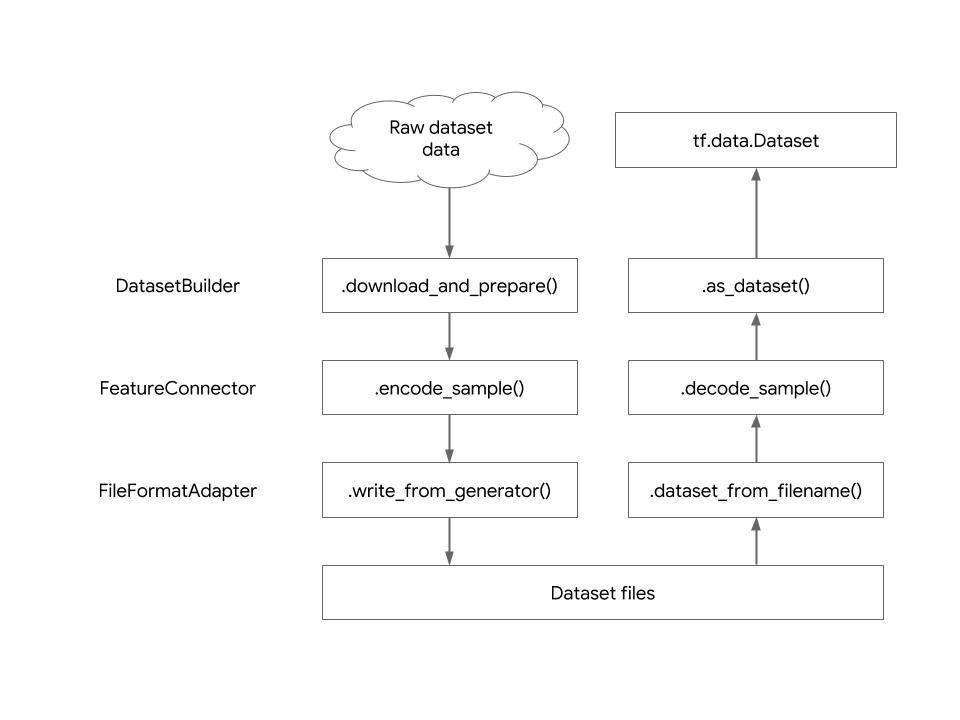

In [ ]:
class MyDataset(tfds.core.GeneratorBasedBuilder):
  """This is a class utilized to create tf.data.Dataset object

  Args:
    tfds (Package): _description_

  Yields:
    _type_: _description_
  """
    
  VERSION = tfds.core.Version('0.1.0')

  def _info(self):
    return tfds.core.DatasetInfo(
        builder=self,
        # 这是将在数据集页面上显示的描述。
        description=("This is the dataset for GeneNet. It contains different"),
        # tfds.features.FeatureConnectors
        features=tfds.features.FeaturesDict({
            "tensor_description": tfds.features.Text(),
            "tensor": tfds.features.Tensor(shape=(GENE_NUMBER, 1), dtype=tf.float64),
            "label": tfds.features.ClassLabel(num_classes=2),
            
        }),
        # 如果特征中有一个通用的（输入，目标）元组，
        # 请在此处指定它们。它们将会在
        # builder.as_dataset 中的 
        # as_supervised=True 时被使用。
        supervised_keys=("tensor", "label"),
    )

  def _split_generators(self, dl_manager):
    # 下载数据并定义划分
    # dl_manager 是一个 tfds.download.DownloadManager，其能够被用于
    # 下载并提取 URLs
    tfds.download.DownloadManager.download_and_extract
    dl_paths = dl_manager.download_and_extract({
      'somatic_mutation_list': 'https://static-content.springer.com/esm/art%3A10.1038%2Fs41588-018-0078-z/MediaObjects/41588_2018_78_MOESM4_ESM.txt',
      'clinical_data': 'https://static-content.springer.com/esm/art%3A10.1038%2Fs41588-018-0078-z/MediaObjects/41588_2018_78_MOESM5_ESM.xlsx',
      'copy_number_variation': 'https://static-content.springer.com/esm/art%3A10.1038%2Fs41588-018-0078-z/MediaObjects/41588_2018_78_MOESM10_ESM.txt',
  })
    
    

  def _generate_examples(self):
    # 从数据集中产生样本
    for 
    yield 'key', {}